In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [8]:

% cd My Drive

% cd Colab Notebooks


/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks


In [0]:
#!unzip 2d_images.zip

In [0]:
#!unzip 2d_masks.zip

In [0]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [0]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

## Load and resize the images

In [0]:
IMAGE_LIB = '/gdrive/My Drive/Colab Notebooks/PatientC/PatientCraw/'
MASK_LIB = '/gdrive/My Drive/Colab Notebooks/PatientC/PatientCfill/'
IMG_HEIGHT, IMG_WIDTH = 256, 256
SEED=42

In [45]:
all_images = [x for x in sorted(os.listdir(IMAGE_LIB)) if x[-4:] == '.jpg']

print(all_images)
x_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(IMAGE_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

    
all_images = [x for x in sorted(os.listdir(MASK_LIB)) if x[-4:] == '.jpg']
y_data = np.empty((len(all_images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(all_images):
    im = cv2.imread(MASK_LIB + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    y_data[i] = im
    
    
    
    
    

['IM-0001-0308.jpg', 'IM-0001-0309.jpg', 'IM-0001-0320.jpg', 'IM-0001-0321.jpg', 'IM-0001-0322.jpg', 'IM-0001-0323.jpg', 'IM-0001-0326.jpg', 'IM-0001-0332.jpg', 'IM-0001-0334.jpg', 'IM-0001-0335.jpg', 'IM-0001-0336.jpg', 'IM-0001-0337.jpg']


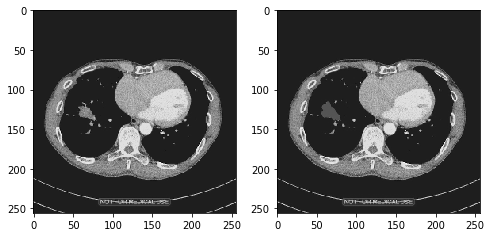

In [46]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [0]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)

## Define and train model

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [0]:
input_layer = Input(shape=x_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
l = MaxPool2D(strides=(2,2))(c1)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
c4 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c4)
c5 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c5)
c6 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c6)
c7 = Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c7)
c8 = Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c8)
c9 = Conv2D(filters=256, kernel_size=(2,2), activation='relu', padding='same')(l)


l = concatenate([UpSampling2D(size=(2,2))(c9), c8], axis=-1)

l = Conv2D(filters=256, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c7], axis=-1)
l = Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c6], axis=-1)
l = Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c5], axis=-1)
l = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c4], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)

In [50]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 8)  80          input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 128, 128, 16) 1168        max_pooling2d_17[0][0]           
____________________________________________________________________________________________

In [0]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

By using the same RNG seed in both calls to ImageDataGenerator, we should get images and masks that correspond to each other. Let's check this, to be safe.

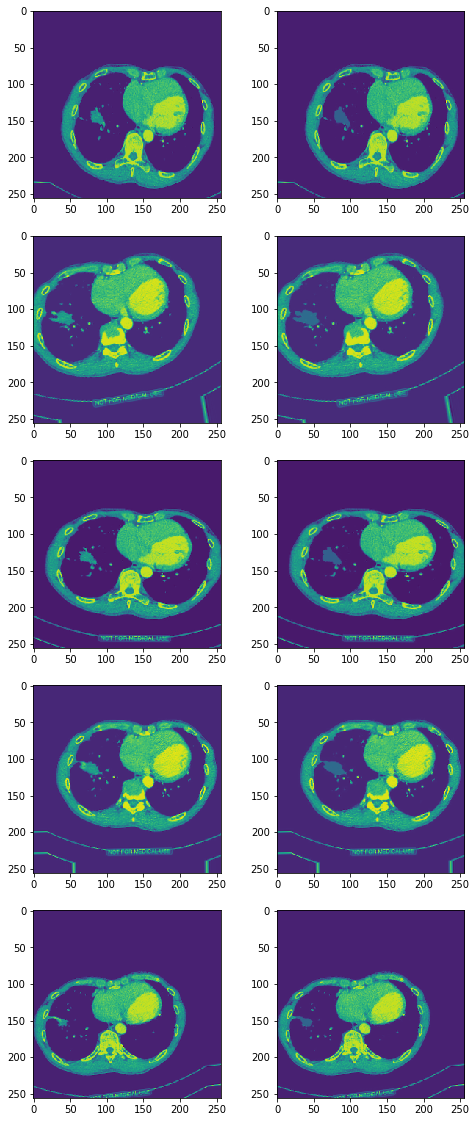

In [52]:
image_batch, mask_batch = next(my_generator(x_train, y_train, 8))
fix, ax = plt.subplots(5,2, figsize=(8,20))
for i in range(5):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [0]:
model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])

In [0]:
weight_saver = ModelCheckpoint('/gdrive/My Drive/Colab Notebooks/lung_kuantan.h5', monitor='val_dice_coef', 
                                              save_best_only=True, save_weights_only=True)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [55]:
hist = model.fit_generator(my_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=1,
                           callbacks = [weight_saver, annealer])

Epoch 1/10
200/200 [==============================] - 14s 71ms/step - loss: 0.4754 - dice_coef: 0.3998 - val_loss: 0.4362 - val_dice_coef: 0.4308
Epoch 2/10
200/200 [==============================] - 12s 60ms/step - loss: 0.4495 - dice_coef: 0.4301 - val_loss: 0.4346 - val_dice_coef: 0.4309
Epoch 3/10
200/200 [==============================] - 12s 62ms/step - loss: 0.4488 - dice_coef: 0.4312 - val_loss: 0.4338 - val_dice_coef: 0.4331
Epoch 4/10
200/200 [==============================] - 13s 63ms/step - loss: 0.4488 - dice_coef: 0.4324 - val_loss: 0.4334 - val_dice_coef: 0.4346
Epoch 5/10
200/200 [==============================] - 13s 63ms/step - loss: 0.4481 - dice_coef: 0.4317 - val_loss: 0.4331 - val_dice_coef: 0.4356
Epoch 6/10
200/200 [==============================] - 12s 61ms/step - loss: 0.4480 - dice_coef: 0.4320 - val_loss: 0.4330 - val_dice_coef: 0.4351
Epoch 7/10
200/200 [==============================] - 12s 62ms/step - loss: 0.4477 - dice_coef: 0.4317 - val_loss: 0.4330 - 

## Evaluate

In [0]:
model.load_weights('/gdrive/My Drive/Colab Notebooks/lung_kuantan.h5')

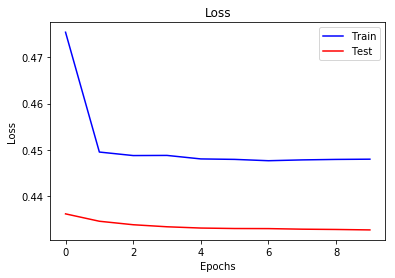

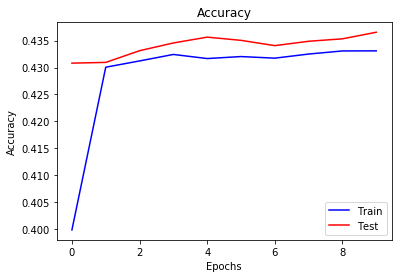

In [57]:
plt.plot(hist.history['loss'], color='b', label="Train")
plt.plot(hist.history['val_loss'], color='r', label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(hist.history['dice_coef'], color='b', label="Train")
plt.plot(hist.history['val_dice_coef'], color='r', label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

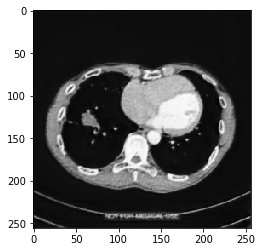

In [58]:
plt.imshow(model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

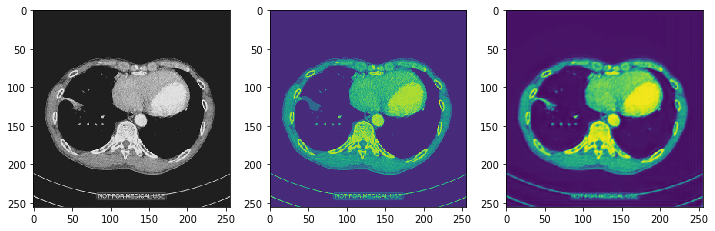

In [62]:
y_hat = model.predict(x_val)
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(x_val[0,:,:,0], cmap='gray')
ax[1].imshow(y_val[0,:,:,0])
ax[2].imshow(y_hat[0,:,:,0])